In [1]:
import os
import sys
import numpy as np
import pandas as pd
import random

In [2]:
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
from utilities.data_downloader import train_val_test_downloader, choose_one_column
from utilities.plots import plt, COLORMAP, visualize_latent
from utilities.dtw import DTWdistanceMatrix

In [4]:
from sklearn.cluster import DBSCAN
from sklearn.manifold import Isomap
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline

In [5]:
random.seed(42)
np.random.seed(42)

# Analysis Pipeline

In [6]:
def make_pipe(eps:float, metric:str):
    """
    Makes pipeline
    """
    return Pipeline(
        [
         ('scaler', RobustScaler()),
        ] * int(metric!='precomputed') +
        [
         ('DBSCAN', DBSCAN(eps=eps, metric=metric)),
        ]
    )

# DTW distance on raw dataset

In [7]:
train, val, test, labels = train_val_test_downloader('original')
train, val, test = tuple(
    map(lambda df: df['lgRate'],
    (train, val, test))
)

Datasets downloaded
 - train  : 810 entries
 - val    : 174 entries
 - test   : 174 entries
 - labels : 1158 entries


In [8]:
X = [np.array([el for el in entry if 
               np.issubdtype(type(el), np.number)], dtype=float)
     for df in (train, val, test) for entry in df.values]

In [9]:
distance_matrix = DTWdistanceMatrix(X)

100%|███████████████████████████████████████| 1158/1158 [03:51<00:00,  5.01it/s]


In [10]:
n_samples = len(X)
pairwise_distances = np.array(
    [distance_matrix[i, j] for i in range(n_samples) for j in range(i)]
)

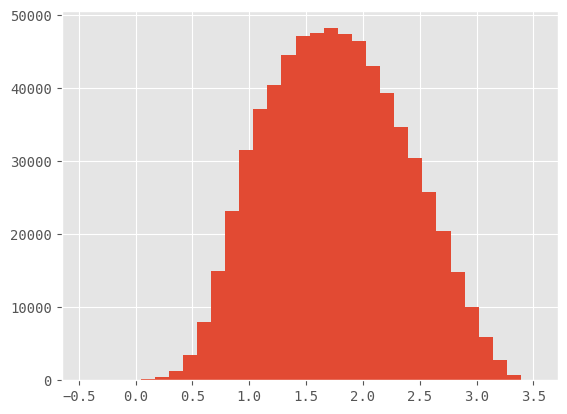

In [11]:
plt.hist(np.log10(pairwise_distances), bins=32)
plt.show()

In [12]:
epsilon = np.logspace(-1, 3, 1000)

In [13]:
n_classes = np.array([], dtype=int)
n_noisy = np.array([], dtype=int)

for eps in epsilon:
    pipe = make_pipe(eps=eps, metric='precomputed')
    preds = pipe.fit_predict(distance_matrix)
    classes, counts = np.unique(preds, return_counts=True)
    n_classes = np.append(n_classes, len(classes)-1)
    n_noisy = np.append(n_noisy, counts[0])

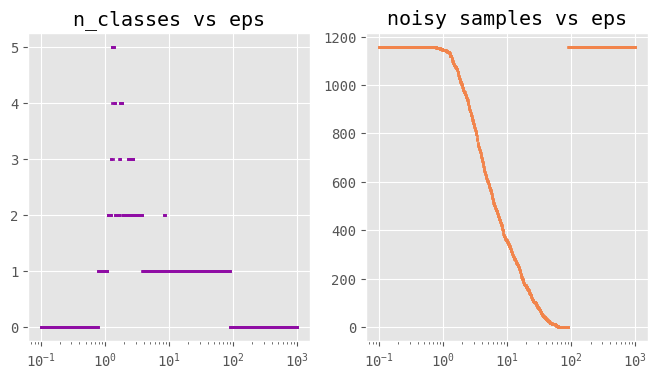

In [14]:
fig, axes = plt.subplots(ncols=2, figsize=(8, 4))

axes[0].scatter(epsilon, n_classes, marker='s', s=4, color=COLORMAP(0.3))
axes[0].set_xscale('log')
axes[0].set_title('n_classes vs eps')
axes[1].scatter(epsilon, n_noisy, marker='s', s=4, color=COLORMAP(0.7))
axes[1].set_xscale('log')
axes[1].set_title('noisy samples vs eps')

plt.show()

In [15]:
n_scan = 1000
epsilon_scan = np.logspace(1, 2, n_scan)
scores = pd.DataFrame(data=np.zeros(n_samples), index=labels.index, columns=['score'])

In [16]:
for eps in epsilon_scan:
    pipe = make_pipe(eps=eps, metric='precomputed')
    preds = pipe.fit_predict(distance_matrix)
    scores.loc[preds==-1, :] = scores.loc[preds==-1, :] + 1/n_scan

In [17]:
# manifold representation
n_components=3
isomap = Isomap(n_components=n_components,
                eigen_solver='dense',
                metric='precomputed').fit(distance_matrix)
features = pd.DataFrame(index=labels.index, data=isomap.embedding_,
                        columns=['feature_%d' % i 
                                 for i in range(n_components)])

In [18]:
df = pd.concat((features, scores, labels), axis=1, ignore_index=False)

In [19]:
print('ROC_AUC Score:\n\t',
      round(roc_auc_score(df['FlaresFlag'].values, df['score'].values), 2)
     )

ROC_AUC Score:
	 0.76


In [20]:
# top-10 anomalous
df.sort_values(by='score').tail(10)

,feature_0,feature_1,feature_2,score,numbreaks,lc type,NH_gal,Redshift,Flares,FlaresFlag
GRB,,,,,,,,,,
GRB 111215A,-25.516105,40.583912,-1.212028,0.747,5,Canonical,0.0726,NaN,"[(407, 460), (576, 701), (882, 1338)]",1
GRB 140506A,86.197681,-38.400784,36.664729,0.756,2,Oddball,0.1100,0.889,"[(96.0, 600)]",1
GRB 050820A,-36.059626,21.081431,0.400821,0.761,3,Canonical,0.0522,2.612,"[(218, 4698)]",1
GRB 180728A,-53.585460,-14.733095,-6.579185,0.763,5,Oddball,0.3200,0.117,[],0
GRB 060729,70.487709,-46.002862,-41.222412,0.764,5,Canonical,0.0540,0.540,"[(130, 146), (166, 225)]",1
GRB 111016A,-13.508048,67.618984,0.560838,0.768,1,One-break,0.0281,NaN,"[(205, 333), (392, 6024)]",1
GRB 090417B,-37.176633,51.970281,-25.196218,0.786,3,Canonical,0.0169,0.345,"[(473, 603), (605, 655), (1229, 5582)]",1
GRB 140206A,58.971178,15.658323,48.789054,0.792,4,Canonical,0.0699,2.730,"[(40.6, 125), (163, 514)]",1
GRB 200509A,5.853359,35.274761,93.612339,0.794,2,Canonical,0.1600,NaN,"[(262, 1332)]",1


In [21]:
fragment = df[
    [col for col in df.columns if col.startswith('feature_')]+
    ['numbreaks']
].values

print('correlation between latent features and '+
      f'numbreaks: {np.corrcoef(fragment, rowvar=False)[:-1, -1]}'
)

correlation between latent features and numbreaks: [ 0.42654516  0.12358779 -0.18925224]


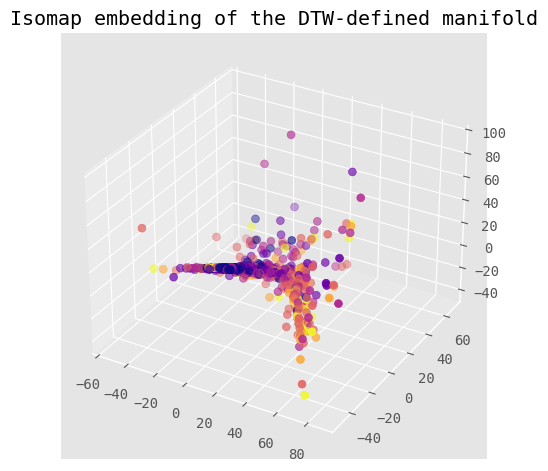

In [22]:
if not os.path.isdir('./Figures'):
    os.mkdir('./Figures')
    
visualize_latent(df, savedir='./Figures',
                 title='Isomap embedding of the DTW-defined manifold', show=True)

# Euclidian distance on rebinned dataset

In [23]:
train, val, test, labels = train_val_test_downloader('interp')
train, val, test = tuple(
    map(lambda df: choose_one_column(df, 'lgRate'),
    (train, val, test))
)

Datasets downloaded
 - train  : 810 entries
 - val    : 174 entries
 - test   : 174 entries
 - labels : 1158 entries


In [24]:
X = pd.concat((train, val, test), axis=0, ignore_index=False)

In [25]:
epsilon = np.logspace(-1, 1, 1000)

In [26]:
n_classes = np.array([], dtype=int)
n_noisy = np.array([], dtype=int)

for eps in epsilon:
    pipe = make_pipe(eps=eps, metric='euclidean')
    preds = pipe.fit_predict(X)
    classes, counts = np.unique(preds, return_counts=True)
    n_classes = np.append(n_classes, len(classes)-1)
    n_noisy = np.append(n_noisy, counts[0])

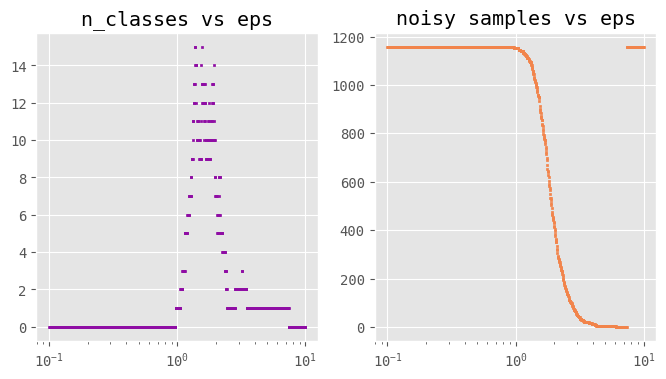

In [27]:
fig, axes = plt.subplots(ncols=2, figsize=(8, 4))

axes[0].scatter(epsilon, n_classes, marker='s', s=4, color=COLORMAP(0.3))
axes[0].set_xscale('log')
axes[0].set_title('n_classes vs eps')
axes[1].scatter(epsilon, n_noisy, marker='s', s=4, color=COLORMAP(0.7))
axes[1].set_xscale('log')
axes[1].set_title('noisy samples vs eps')

plt.show()

In [28]:
n_scan = 1000
epsilon_scan = np.logspace(0, 1, n_scan)
scores = pd.DataFrame(data=np.zeros(n_samples), index=labels.index, columns=['score'])

In [29]:
for eps in epsilon_scan:
    pipe = make_pipe(eps=eps, metric='euclidean')
    preds = pipe.fit_predict(X)
    scores.loc[preds==-1, :] = scores.loc[preds==-1, :] + 1/n_scan

In [30]:
# manifold representation
n_components=3
isomap = Isomap(n_components=n_components,
                eigen_solver='dense',
                metric='euclidean').fit(X)
features = pd.DataFrame(index=labels.index, data=isomap.embedding_,
                        columns=['feature_%d' % i 
                                 for i in range(n_components)])

In [31]:
df = pd.concat((features, scores, labels), axis=1, ignore_index=False)

In [32]:
print('ROC_AUC Score:\n\t',
      round(roc_auc_score(df['FlaresFlag'].values, df['score'].values), 2)
     )

ROC_AUC Score:
	 0.74


In [33]:
# top-10 anomalous
df.sort_values(by='score').tail(10)

,feature_0,feature_1,feature_2,score,numbreaks,lc type,NH_gal,Redshift,Flares,FlaresFlag
GRB,,,,,,,,,,
GRB 111209A,16.887932,-8.196654,-3.019530,0.619,4,Canonical,0.0154,0.677,"[(565, 655), (659, 898), (1208, 1675), (1680, ...",1
GRB 180720B,17.838773,-8.698613,0.484941,0.625,4,Canonical,0.0392,0.654,"[(81.8, 147), (438, 524), (540, 553), (563, 599)]",1
GRB 130427A,20.817997,-9.923854,0.460419,0.626,5,Oddball,0.0191,0.340,"[(226, 272)]",1
GRB 200509A,0.329686,-4.631813,3.047253,0.626,2,Canonical,0.1600,NaN,"[(262, 1332)]",1
GRB 210212A,-9.525809,13.323217,-0.901502,0.630,1,One-break,0.1100,NaN,[],0
GRB 080603B,6.866297,-3.379701,12.665437,0.636,1,One-break,0.0127,2.690,[],0
GRB 120711A,7.042234,-7.321883,4.507958,0.648,0,No breaks,0.1100,1.405,[],0
GRB 170906B,-0.823155,-8.717809,12.790098,0.739,0,No breaks,0.1700,NaN,[],0
GRB 200416A,1.064263,-8.842257,17.151938,0.783,1,One-break,0.0654,NaN,[],0


In [34]:
fragment = df[
    [col for col in df.columns if col.startswith('feature_')]+
    ['numbreaks']
].values

print('correlation between latent features and '+
      f'numbreaks: {np.corrcoef(fragment, rowvar=False)[:-1, -1]}'
)

correlation between latent features and numbreaks: [ 0.70508401  0.0275461  -0.09582395]


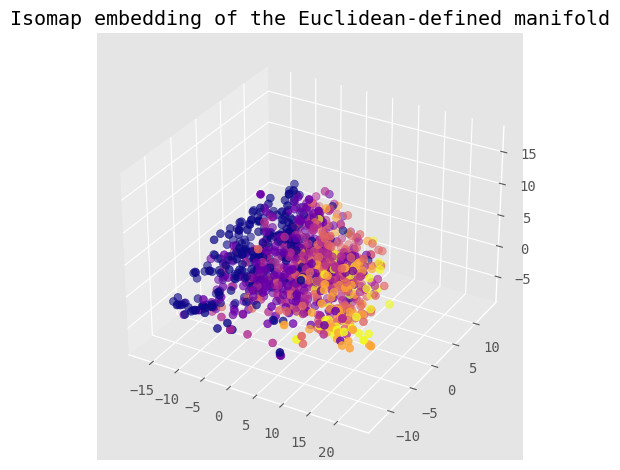

In [35]:
if not os.path.isdir('./Figures'):
    os.mkdir('./Figures')
    
visualize_latent(df, savedir='./Figures',
                 title='Isomap embedding of the Euclidean-defined manifold', show=True)